## Generated Events vs. Real Events

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%cd ..

/scratch/ml/cyeh/sustaingym


In [2]:
from datetime import datetime
import pytz
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sustaingym.envs.evcharging import GMMsTraceGenerator, RealTraceGenerator
from sustaingym.envs.evcharging import utils
from sustaingym.envs.evcharging.train_gmm_model import preprocess

## Create Generators

In [3]:
ag = GMMsTraceGenerator('caltech', 'Summer 2019')
rg = RealTraceGenerator('caltech', 'Summer 2019', sequential=True)
rg = RealTraceGenerator('caltech', 'Summer 2019', sequential=False)

## Real Events

In [4]:
def plot_gmm_fit(site):
    la_tz = pytz.timezone('America/Los_Angeles')
    dtf = '%Y-%m-%d'

    seasons = ['Summer 2019', 'Fall 2019', 'Spring 2020', 'Summer 2021']
    periods = []
    dfs = []
    gmms = []
    pdfs = []

    # display predicted scores by the model as a contour plot
    arr = np.linspace(0.0, 1.0)
    dep = np.linspace(0.0, 1.0)

    # Fit gmm on mesh to generate contour lines
    X, Y = np.meshgrid(arr, dep)
    Xr, Yr = X.ravel(), Y.ravel()
    N = len(Xr)
    x_b = np.vstack((Xr, Yr))  # shape (2, N)

    for season in seasons:
        period = (datetime.strptime(utils.DEFAULT_PERIOD_TO_RANGE[season][0], dtf).replace(tzinfo=la_tz),
                  datetime.strptime(utils.DEFAULT_PERIOD_TO_RANGE[season][1], dtf).replace(tzinfo=la_tz))
        periods.append(period)

        df = preprocess(utils.get_real_events(period[0], period[1], site))
        dfs.append(df)

        gmm = utils.load_gmm_model(site, period[0], period[1], 30)['gmm']
        gmms.append(gmm)

        # Calculate conditional mean for estimated departure, requested energy
        weights = np.expand_dims(gmm.weights_, (1, 2))
        n_components = len(gmm.weights_)

        conditional_means = []
        for i in range(n_components):
            mu_a = np.expand_dims(gmm.means_[i, 2:], 1)
            mu_b = np.expand_dims(gmm.means_[i, :2], 1)
            mu_aa_precision = gmm.precisions_[i, 2:, 2:]
            mu_ab_precision = gmm.precisions_[i, 2:, :2]
            cond_a_b = mu_a - np.linalg.pinv(mu_aa_precision) @ mu_ab_precision @ (x_b - mu_b)
            conditional_means.append(cond_a_b)
        conditional_means = np.array(conditional_means)
        conditional_mean = np.sum(weights * conditional_means, axis=0).T  # N, 2

        gmm_input = pd.DataFrame({
            'arrival_time': Xr,
            'departure_time': Yr,
            'estimated_departure_time': conditional_mean[:, 0],
            'requested_energy (kWh)': conditional_mean[:, 1]
        })
        Z = gmm.score_samples(gmm_input)
        Z = Z.reshape(X.shape)

        pdfs.append((X, Y, Z))

    fig, axs = plt.subplots(1, 4, sharey=True, figsize=(12, 3.5), tight_layout=True)
    for i, ax in enumerate(axs):
        X, Y, Z = pdfs[i]
        x = X * 288 # rescale to 5-min periods
        y = Y * 288
        # same with arrivals and departures
        arr_time = dfs[i].arrival_time * 288
        dep_time = dfs[i].departure_time * 288

        cp = ax.contourf(x, y, Z, cmap='Oranges', alpha=0.5)
        ax.scatter(arr_time, dep_time, marker='+', alpha=0.2, color='tab:blue')
        ax.set(xlabel='arrival time', title=f'{seasons[i]}')
        ax.set_aspect('equal', 'box')
        ax.set_xticks([0, 96, 192, 288], labels=['0:00', '8:00', '16:00', '24:00'])

    axs[0].set_ylabel('departure time')
    axs[0].set_yticks([0, 96, 192, 288], labels=['0:00', '8:00', '16:00', '24:00'])

    # fig.subplots_adjust(right=0.8)
    # if site == 'caltech':
    #     fig.suptitle(f'GMM Fit for the Caltech site')
    # else:
    #     fig.suptitle(f'GMM Fit for the JPL site')
    cbar_ax = fig.add_axes([1, 0.18, 0.02, 0.66])
    cbar = fig.colorbar(cp, cax=cbar_ax)
    cbar.ax.set_ylabel('log-likelihood', rotation=270)
    fig.savefig(f'gmms_fit_{site}.png', dpi=300, bbox_inches='tight', pad_inches=0)

Fetching caltech sessions from 2020-02-01 to 2020-06-01 from ACNData


/tmp/ipykernel_15562/2433172412.py:84: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.savefig(f'gmms_fit_{site}.png', dpi=300, bbox_inches='tight', pad_inches=0)
/scratch/ml/cyeh/miniconda3/envs/sustaingym/lib/python3.9/site-packages/IPython/core/events.py:89: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  func(*args, **kwargs)
/scratch/ml/cyeh/miniconda3/envs/sustaingym/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


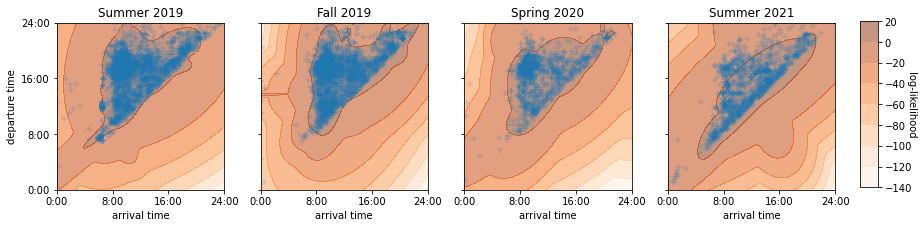

In [5]:
plot_gmm_fit('caltech')

Fetching jpl sessions from 2020-02-01 to 2020-06-01 from ACNData


/tmp/ipykernel_15562/2433172412.py:84: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.savefig(f'gmms_fit_{site}.png', dpi=300, bbox_inches='tight', pad_inches=0)
/scratch/ml/cyeh/miniconda3/envs/sustaingym/lib/python3.9/site-packages/IPython/core/events.py:89: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  func(*args, **kwargs)
/scratch/ml/cyeh/miniconda3/envs/sustaingym/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


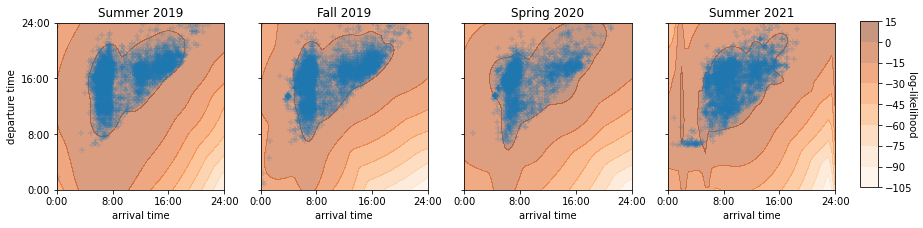

In [6]:
plot_gmm_fit('jpl')